In [1]:
!nvidia-smi

Tue Jul 27 15:02:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import gzip


from time import sleep
from pathlib import Path


import h5py
import json 


import itertools
from collections import Counter

import numpy as np
import cv2


from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision.transforms as TRNS
from torchvision.datasets import QMNIST

In [3]:
# #@title This is a preprocessing step to create KDEF cropped dataset { form-width: "20%" }

# !wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
# !unzip -qo "/content/drive/MyDrive/Academics/Courses/Deep Learning/Final Project/KDEF_and_AKDEF.zip"


# face_cascade = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
    
# def unformat_filename(fname):
#     return {
#         "session": fname[0],
#         "id": fname[1:4], #gender + id
#         "expression": fname[4:6],
#         "angle": fname[6:-4]
#     }


# def crop_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.equalizeHist(gray)
#     #-- Detect faces
#     faces = face_cascade.detectMultiScale(gray,
#                                           scaleFactor=1.1,
#                                           minNeighbors=3,
#                                           flags = 0,
#                                           minSize=(20,20))
#     flag = len(faces) == 1
#     (x, y, w, h) = faces[0]
#     return img[y:y+h, x:x+w], flag # y,x coordinate in python


# raw_data_folder = "/content/KDEF_and_AKDEF/KDEF"
# file_count = sum(len(files) for _, _, files in os.walk(raw_data_folder))

# pbar = tqdm(total=file_count)
# for root, __, files in os.walk(raw_data_folder):
#     for f in files:
#         pbar.update()
#         label_info = unformat_filename(f)
#         if label_info["angle"] != "S":
#             continue
#         src_fpath = os.path.join(root, f)
#         parname = Path(root).name
#         des_fpath = Path(os.path.join("KDEF_cropped", parname))
#         des_fpath.mkdir(exist_ok=True, parents=True)
#         des_fpath = des_fpath.resolve()
#         des_fpath = os.path.join(des_fpath, f)

#         img = cv2.imread(src_fpath)
#         cropped, flag = crop_face(img)
#         cropped = cv2.resize(cropped, (158,158))
#         if flag is False:
#             continue
#         cv2.imwrite(des_fpath, cropped)

# !zip -qo -r KDEF_cropped.zip KDEF_cropped/
# !mv KDEF_cropped.zip "/content/drive/MyDrive/Academics/Courses/Deep Learning/Final Project/KDEF_cropped.zip"

### Unzipping the dataset

In [4]:
!unzip -qo "/content/drive/MyDrive/Academics/Courses/Deep Learning/Final Project/KDEF_cropped.zip"

In [5]:
# # Face expressions
# ''' 
#     AF = afraid
#     AN = angry
#     DI = disgusted
#     HA = happy
#     NE = neutral
#     SA = sad
#     SU = surprised
# '''


# # Angles
# '''
#     FL = full left profile
#     HL = half left profile
#     S = straight
#     HR = half right profile
#     FR = full right profile
# '''

### Defining constants

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

MODEL_SAVE_LOCATION = "/content/drive/MyDrive/Academics/Courses/Deep Learning/Final Project/"



# TRAINING PARAMS
LR = 2e-4
WEIGHT_DECAY = 0
ADAM_EPSILON = 1e-8


LR_SCHEDULER_START_FROM = 1_000
LR_SCHEDULER_STEP = 5_000
LR_SCHEDULER_COEF = 0.5

MAX_ITERATIONS = 40_000
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 128

MAX_GRADIENT_NORM = 1

REPORT_STEP = 1000
SAVE_STEP = 2000

# EUCLIDEAN_LOSS = "L1"
# EUCLIDEAN_LOSS = "Smooth"
EUCLIDEAN_LOSS = "L2"



MAX_EPOCHS = 200
EARLY_STOPPING_PATIENCE = 3

In [7]:
# DATASET CONSTANTS
__VALID_EMOTIONS = ["DI", "HA", "NE", "SU"]

KDEF_CONSTANTS = dict(
        DATASET_PATH="/content/KDEF_cropped",
        VALID_EMOTIONS = __VALID_EMOTIONS,
        NUM_EMOTIONS=len(__VALID_EMOTIONS),
        NUM_TRANSFORMS=8,
        NUM_TRANSFORMS_TEST_SPLIT=4,
        INPUT_SHAPE = (3, 158, 158),
        BETAS= (0.9, 0.99),
        NUM_PERSONS_GENERATION=70,
        GENERATION_TEST_SIZE=10,
        NUM_PERSONS_CLASSIFICATION=45,
        NUM_PERSONS_VALIDATION = 5,
        CLASSIFIER_BETAS = (0.9, 0.999),
        CLASSIFIER_WEIGHT_DECAY=0.002,
)


MNIST_CONSTANTS = dict(NUM_DIGITS = 10,
                       NUM_TRANSFORMS=8,
                       NUM_TRANSFORMS_TEST_SPLIT=4,
                       NUM_COLOR_CHANNELS = 3, 
                       INPUT_SHAPE = (28, 28),
                       BETAS=(0.9, 0.995),
                       NUM_WRITERS=100,
                       TOTAL_MNIST_WRITERS=610,
                       GENERATION_TEST_SIZE=10,
                       )

In [8]:
def INIT_GENERATION_CLASSIFICATION_SET_SPLIT(paper_sets=False, validation=False):
    assert paper_sets ^ validation
    if paper_sets:
        KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"] = 65
    else:
        KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"] = 45
        KDEF_CONSTANTS["NUM_PERSONS_VALIDATION"] = 5

### Defining label encoders

In [9]:
EMOTION_ENCODER = {
    k: idx for idx, k in enumerate(KDEF_CONSTANTS["VALID_EMOTIONS"])
}


unique_ids = set([folder_name[1:] for folder_name in sorted(
    os.listdir(KDEF_CONSTANTS["DATASET_PATH"]))
])

ID_ENCODER = {
           uuid: idx for idx, uuid in enumerate(sorted(unique_ids))
}

SESSION_ENCODER = {"A": 0, "B": 1}
print(EMOTION_ENCODER)

{'DI': 0, 'HA': 1, 'NE': 2, 'SU': 3}


### Defining KDEF dataset reader

In [10]:
def apply_affine_transform(x, transform_id):
    result = None
    rotation_id = transform_id % 4
    if rotation_id == 0:
        result = x
    elif rotation_id % 4 == 1:
        result = cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif rotation_id % 4 == 2:
        result = cv2.rotate(x, cv2.ROTATE_180)
    else:
        result = cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE)
    
    flip_id = transform_id // 4
    if flip_id == 0:
        result = result
    else:
        result = np.fliplr(result)
    return result


In [11]:
def unformat_filename(fname):
    return {
        "session": fname[0],
        "id": fname[1:4], #gender + id
        "emotion": fname[4:6],
        "angle": fname[6:-4]
    }

class KDEFAugmenter:
    def __init__(self):
        pass

    def __call__(self, data):
        augmented = []
        for d in data:
            aug_imgs = self.augment(d)
            augmented.extend(aug_imgs)
        return augmented
    
    def augment(self, data):
        img = data['img']
        transforms = data["transform"]
        result = []
        for idx in transforms:
            aug = apply_affine_transform(img, idx)
            result.append(
                {
                    "img": aug.copy(),
                    "id": data["id"],
                    "emotion": data["emotion"],
                    "transform": idx,
                }
            )
        return result   

class KDEFDatasetReader:
    def __init__(self, src, seed=12345):
        self.src = src
        self.rng = np.random.default_rng(seed)
        self.augmenter = KDEFAugmenter()
    
    def _read_dataset(self, 
                      valid_emotions, 
                      session=None):
        data_tree = {
            id: [] for id in ID_ENCODER.values()
        }
        for root, __, files in os.walk(self.src):
            for f in files:
                label_info = unformat_filename(f)
                person_id = ID_ENCODER[label_info["id"]]
                if session is not None and session != label_info["session"]:
                    continue
                if label_info["emotion"] in valid_emotions:
                    img = cv2.imread(
                        os.path.join(root, f)
                    )
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    data_tree[person_id].append(
                        {
                            "img": img,
                            "id": person_id,
                            "session": SESSION_ENCODER[label_info["session"]],
                            "emotion": EMOTION_ENCODER[label_info["emotion"]],
                            "transform": list(range(KDEF_CONSTANTS["NUM_TRANSFORMS"]))
                        }
                    )
        return data_tree
    
    def _split_generator_train_test(self, data_tree):
        train_data = []
        test_emotions = []
        test_transformations = []
        

        test_size = KDEF_CONSTANTS["GENERATION_TEST_SIZE"]

        ids = list(ID_ENCODER.values())
        self.rng.shuffle(ids)
        
        train_ids = ids[:-test_size]
        test_ids = ids[-test_size:]


        for i in train_ids:
            for d in data_tree[i]:
                train_data.append(d)
        
        train_data = self.augmenter(train_data)
        
            
            
        test_emotion_indices = self.rng.choice(range(KDEF_CONSTANTS["NUM_EMOTIONS"]), size=test_size)
        for t, test_emotion_index in zip(test_ids, test_emotion_indices):
            for idx, d in enumerate(data_tree[t]):
                # Expression
                if t % 2 == 0: 
                    if d["emotion"] == test_emotion_index:
                        d["transform"] = 0
                        test_emotions.append(d)
                    else:
                        # appending all other expressions
                        train_data.append(d)
                        
                # Transformations
                else: 
                    augs = self.augmenter.augment(d)
                    self.rng.shuffle(augs)
                    split = KDEF_CONSTANTS["NUM_TRANSFORMS_TEST_SPLIT"]
                    # a single image should exist
                    train_data.extend(augs[:split])
                    test_transformations.extend(augs[split:])

        
        return train_data, test_emotions, test_transformations

    def _split_classification_sets(self, 
                                   data_tree, 
                                   paper_sets=False, 
                                   validation=False):
        # both can't be True or False at the same time
        assert paper_sets ^ validation
        # generator data is single session
        print(f"Number of unique people in the training set of classification {KDEF_CONSTANTS['NUM_PERSONS_CLASSIFICATION']}")

        train_data = []
        if validation:
            val_data = []
        test_data = []
        
        ids = list(ID_ENCODER.values())
        self.rng.shuffle(ids)

        id_mapper = {
            old_id: new_id for new_id, old_id in enumerate(ids)
        }

        if validation:
            train_size = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
            val_size = KDEF_CONSTANTS["NUM_PERSONS_VALIDATION"]
            train_ids = ids[:train_size]
            val_ids = ids[train_size: train_size + val_size]
            test_ids = ids[train_size+val_size:]
            print(
                f"Train Size: {len(train_ids)}\t Val Size: {len(val_ids)}\t Test Size: {len(test_ids)}"
            )
        else:
            train_size = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
            train_ids = ids[:train_size]
            test_ids = ids[train_size:]
            print(
                f"Train Size: {len(train_ids)}\t Test Size: {len(test_ids)}"
            )


        for t in data_tree:
            for d in data_tree[t]:
                d['id'] = id_mapper[d['id']]
                if d["session"] == 0:
                    if t in train_ids:
                        augs = self.augmenter.augment(d)
                        train_data.extend(augs)
                    elif t in test_ids:
                        d['transform'] = 0
                        test_data.append(d)
                    elif validation is True and t in val_ids:
                        d['transform'] = 0
                        val_data.append(d)
                    else:
                        raise ArithmeticError("Train/Test/Val or Train/Test")
                elif paper_sets:
                    test_data.append(d)
                else:
                    pass


        if validation:
            return train_data,  test_data, val_data
        elif paper_sets:
            return train_data,  test_data,
        else:
            raise ArithmeticError("Both validation and paper sets cannot be false.")


    def read(self, valid_emotions, dataset_type, session=None, **classification_kwargs):
        assert dataset_type in ["generator", "classifier"]
        data_tree = self._read_dataset(valid_emotions, session=session)
        if dataset_type == "generator":
            # train_data, test_emotions, test_transformations
            return self._split_generator_train_test(data_tree)
        else:
                # train_data, test_data, val_data
            return self._split_classification_sets(data_tree, **classification_kwargs)

### Defining MNIST dataset reader

In [12]:
class MNISTColorify:
    def __init__(self):
        pass
    
    def __call__(self, img, digit, writer):
        data = []
        for color_idx in range(MNIST_CONSTANTS["NUM_COLOR_CHANNELS"]):
            colored = np.zeros((*img.shape, 3), dtype=np.uint8)
            colored[:, :, color_idx] = img
            data.append({
                "img": colored,
                "digit": digit,
                "color": color_idx,
                "writer": writer,
                "transform": np.arange(MNIST_CONSTANTS["NUM_TRANSFORMS"])
            })
        return data


class MNISTAugmenter:
    def __init__(self):
        pass

    def __call__(self, item):
        transforms = item["transform"]
        aug_imgs = self.augment(item)
        return [
                    {
                        "img": aug.copy(),
                        "digit": item["digit"],
                        "color": item["color"],
                        "writer": item["writer"],
                        "transform": tr,
                    } for aug, tr in zip(aug_imgs, transforms)
                ]
    
    
    def augment(self, data):
        img = data['img']
        transforms = data["transform"]
        result = []
        for idx in transforms:
            aug = apply_affine_transform(img, idx)
            result.append(aug)
        return result




class MNISTDatasetReader:
    def __init__(self, seed=12345):
        self.colorify = MNISTColorify()
        self.augmenter = MNISTAugmenter()
        self.rng = np.random.default_rng(seed)
    

    def _split_writer_ids(self, dataset):
        index_tree = {}
        writer_digits = {}
        for element_idx, (_, target) in enumerate(dataset):
            digit = target[0]
            writer_id = target[2]
            if writer_id not in index_tree:
                index_tree[writer_id] = [element_idx]
                writer_digits[writer_id] = [digit]
            
            else:
                if digit not in writer_digits[writer_id]:
                    index_tree[writer_id].append(element_idx)
                    writer_digits[writer_id].append(digit)
        return index_tree

    def read(self):
        input_transform = lambda x: np.array(x).astype(np.uint8)
        target_transform = lambda x: np.array(x)
        train_dataset = QMNIST(root=".", 
                                  train=True, 
                                  compat=False, 
                                  transform=input_transform,
                                  target_transform=target_transform,
                                  download=True)
        test_dataset = QMNIST(root=".", 
                                 train=False, 
                                 compat=False, 
                                 transform=input_transform,
                                 target_transform=target_transform,
                                 download=True)
        
        dataset = ConcatDataset([train_dataset, test_dataset])

        indices = self._split_writer_ids(dataset)
        
        keys = list(indices.keys())
        self.rng.shuffle(keys)
        
        keys = keys[:MNIST_CONSTANTS["NUM_WRITERS"]]

        

        WRITER_ENCODER = {k: idx for idx, k in enumerate(keys)}
        
        indices = [i for k in keys for i in indices[k]]

        self.rng.shuffle(indices)

        test_size = MNIST_CONSTANTS["GENERATION_TEST_SIZE"]

        train_indices, test_indices = indices[:-test_size], indices[-test_size:]

        train_data = []
        test_data_color = []
        test_data_transform = []

        
        for idx in train_indices:
            img, target = dataset[idx]
            digit, writer = target[0], WRITER_ENCODER[target[2]]
            colored = self.colorify(img, digit, writer)
            for c in colored:
                train_data.extend(self.augmenter(c))

        for idx in test_indices:
            img, target = dataset[idx]
            digit, writer = target[0], WRITER_ENCODER[target[2]]
            colored = self.colorify(img, digit, writer)
            if idx % 2 == 0:
                for c in colored:
                    augs = self.augmenter(c)
                    self.rng.shuffle(augs)
                    split = MNIST_CONSTANTS["NUM_TRANSFORMS_TEST_SPLIT"]
                    train_data.extend(augs[:split])
                    test_data_transform.extend(augs[split:])
                    
            else:
                color_index = idx % 3
                c = colored[color_index]
                # append only a single unseen channel to test set
                test_data_color.append(c)
                # append all other channels to train set
                train_data.extend([colored[c] for c in range(3) if c != color_index])

        return train_data, test_data_color, test_data_transform

### Onehot Transformer

In [13]:
class ToOneHotTensor:
    def __init__(self):
        pass
    def __call__(self, id, n_class):
        one_hot = np.zeros((n_class,))
        one_hot[id] = 1
        one_hot = torch.FloatTensor(one_hot.tolist())
        return one_hot


class CreateSegmentationMap:
    def __init__(self):
        pass
    
    def __call__(self, img, class_id):
        map = (img.mean(axis=-1) > 0).astype(np.float32).copy()
        map = torch.from_numpy(map)
        return map

## Defining KDEFDataset

In [14]:
class KDEFDataset(Dataset):
    def __init__(self,
                 data,
                 dataset_type,
                 image_transforms,
                 classifier_test=False):
        
        self.image_transforms = image_transforms
        self.one_hot_transform = ToOneHotTensor()

        self.data = data
        self.dataset_type = dataset_type
        
        if self.dataset_type == "generator":
            self.NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_GENERATION"]
        else:
            self.NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]

        self._len = len(data)

        assert classifier_test in [True, False]
        self.classifier_test = classifier_test


    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        d = self.data[idx]
        img = d["img"]
        id, emotion, transform = d["id"], d["emotion"], d["transform"]
        
        # Image transformations
        img = self.image_transforms(img)
        
        # Target transformations
        emotion = self.one_hot_transform(emotion, KDEF_CONSTANTS["NUM_EMOTIONS"])

        if not self.classifier_test:
            id = self.one_hot_transform(id, self.NUM_PERSONS)
            transform = self.one_hot_transform(transform, KDEF_CONSTANTS["NUM_TRANSFORMS"])        
            return {
                "img": img,
                "id": id,
                "emotion": emotion,
                "transform": transform,
            }
        else:
            return {
                "img": img,
                "emotion": emotion
            }

In [15]:
def to_uint8(img):
    img = img - img.min()
    img = ((img / img.max()) * 255.0).astype(np.uint8)
    return img

class KDEFDatasetAugmenter:
    class DummyDataset(Dataset):
        def __init__(self, data):
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            return {
                k: torch.FloatTensor(v) for k, v in self.data[idx].items()
            }
    
    def __init__(self, device):
        self.device = device

        self.num_person = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
        self.num_emotion = KDEF_CONSTANTS["NUM_EMOTIONS"]
        self.num_transform = KDEF_CONSTANTS["NUM_TRANSFORMS"]



    def _one_hot_encoder(self, idx, num_labels):
        one_hot = np.zeros((num_labels,))
        one_hot[idx] = 1 
        return one_hot


    def _generate_input_data(self, train_ids):
        one_hot_indexes = [self._one_hot_encoder(idx, self.num_person) for idx in train_ids]
        identities = [(i + j)/2 for i, j in itertools.combinations(one_hot_indexes, 2)]
        emotions = range(self.num_emotion)
        transform = 0
        aug_data = []
        for emotion in emotions:
            for id in identities:
                aug_data.append({
                    "id": id, 
                    "emotion": self._one_hot_encoder(emotion, self.num_emotion), 
                    "transform": self._one_hot_encoder(transform, self.num_transform)
                })
        aug_dataset = KDEFDatasetAugmenter.DummyDataset(aug_data)
        aug_dataloader = DataLoader(dataset = aug_dataset, 
                                    batch_size=TRAIN_BATCH_SIZE, 
                                    shuffle=False)
        return aug_dataloader

    def synthesis_data(self, model, train_data):
        ids = set()
        for d in train_data:
            ids.add(d["id"])
        ids = list(sorted(ids))
        aug_dataloader = self._generate_input_data(ids)
        data = []
        model.eval()
        with torch.no_grad():
            for batch in aug_dataloader:
                persons = batch["id"].to(self.device)
                emotions = batch["emotion"].to(self.device)
                transforms = batch["transform"].to(self.device)
                imgs = model.generator(id=persons, 
                                       emotion=emotions, 
                                       transform=transforms).cpu().numpy().astype(np.float32)
                persons = persons.cpu().numpy().argmax(axis=-1)
                emotions = emotions.cpu().numpy().argmax(axis=-1)
                for idx in range(len(persons)):
                    cur_img = to_uint8(imgs[idx].transpose((1, 2, 0)))
                    d = {
                        "img": cur_img, 
                        "id": persons[idx], 
                        "emotion": emotions[idx], 
                        "transform": list(range(KDEF_CONSTANTS["NUM_TRANSFORMS"]))
                    }
                    data.append(d)
        return data




In [16]:
class KDEFAugmentedDataset(Dataset):
    def __init__(self,
                 data,
                 image_transforms,
                 rotation_augmentation=True):
        
        self.image_transforms = image_transforms
        self.to_one_hot = ToOneHotTensor()
        self.data = data
        self.NUM_TRANSFORMS = KDEF_CONSTANTS["NUM_TRANSFORMS"]
        self.rotation_augmentation = rotation_augmentation
        


    def __len__(self):
        length = len(self.data)
        if self.rotation_augmentation:
            length = length * self.NUM_TRANSFORMS
        return length
    
    def __getitem__(self, n):
        if self.rotation_augmentation:
            transform = n % self.NUM_TRANSFORMS
            idx = n // self.NUM_TRANSFORMS
            img = self.data[idx]["img"]
            img = self.image_transforms(apply_affine_transform(img, transform).copy())
        else:
            idx = n
            img = self.data[idx]["img"]
            img = self.image_transforms(img)
        emotion = self.to_one_hot(self.data[idx]["emotion"], KDEF_CONSTANTS["NUM_EMOTIONS"])

        return {
            "img": img,
            "emotion": emotion,
        }
            


## Defining MNISTDataset

In [17]:
class MNISTDataset(Dataset):
    def __init__(self,
                 data,
                 image_transforms):
        
        self.image_transforms = image_transforms
        self.one_hot_transform = ToOneHotTensor()
        self.segmentation_maker = CreateSegmentationMap()

        self.data = data
        self._len = len(data)

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        d = self.data[idx]
        img = d["img"]
        digit, color, transform, writer = d["digit"], d["color"], d["transform"], d["writer"]
        
        segm = self.segmentation_maker(img, digit)

        img = self.image_transforms(img)

        digit = self.one_hot_transform(digit, MNIST_CONSTANTS["NUM_DIGITS"])
        color = self.one_hot_transform(color, MNIST_CONSTANTS["NUM_COLOR_CHANNELS"])
        transform = self.one_hot_transform(transform, MNIST_CONSTANTS["NUM_TRANSFORMS"])
        writer = self.one_hot_transform(writer, MNIST_CONSTANTS["NUM_WRITERS"])

        

        return {
            "img": img,
            "digit": digit,
            "color": color,
            "transform": transform,
            "writer": writer,
            "segm": segm
        }

# Defining Initializer

In [18]:
class BatchCollater:
    def __call__(self, data):
        result = {
            k: [] for k in data[0].keys()
        }
        for d in data:
            for k in d:
                result[k].append(d[k])
        
        for k in result:
            result[k] = torch.stack(result[k], dim=0)
        
        return result

class Initializer:
    def __init__(self):
        pass
    
    @classmethod
    def init_pretraining_params(self, 
                                dataset_name,
                                dataset_type,
                                debug=False,
                                seed=12345,
                                **read_kwargs):
        
        train_loader_params = dict(batch_size=TRAIN_BATCH_SIZE if not debug else 2,
                                   collate_fn=BatchCollater(),
                                   shuffle=True,
                                   num_workers=2)
        test_loader_params = dict(batch_size=TEST_BATCH_SIZE if not debug else 2, 
                                 collate_fn=BatchCollater(),
                                 shuffle=False)
        image_transforms = TRNS.Compose([TRNS.ToTensor()])
                
        if dataset_name == "KDEF":
            assert dataset_type in ["generator", "classifier"]
            reader = KDEFDatasetReader(KDEF_CONSTANTS["DATASET_PATH"], seed=seed)
            if dataset_type == "generator":
                train_data, test_data_emotion, test_data_transform = reader.read(
                    KDEF_CONSTANTS["VALID_EMOTIONS"],
                    dataset_type,
                    **read_kwargs)
                train_dataset = KDEFDataset(train_data, 
                                            dataset_type, 
                                            image_transforms)
                test_dataset_emotion = KDEFDataset(test_data_emotion, 
                                                   dataset_type, 
                                                   image_transforms)
                test_dataset_transform = KDEFDataset(test_data_transform, 
                                                     dataset_type, 
                                                     image_transforms)
                # Loaders
                train_loader = DataLoader(dataset=train_dataset, **train_loader_params)
                test_loader_emotion = DataLoader(dataset=test_dataset_emotion, **test_loader_params)
                test_loader_transform = DataLoader(dataset=test_dataset_transform, **test_loader_params)
                
                # Defining result
                result = dict(
                    train_dataset=train_dataset,
                    test_dataset_emotion=test_dataset_emotion,
                    test_dataset_transform=test_dataset_transform,
                    train_loader=train_loader,
                    test_loader_emotion=test_loader_emotion,
                    test_loader_transform=test_loader_transform,
                )
            #dataset_type is classifier
            else: 
                validation = read_kwargs.get("validation", False)
                paper_sets = read_kwargs.get("paper_sets", False)
                INIT_GENERATION_CLASSIFICATION_SET_SPLIT(validation=validation, 
                                                         paper_sets=paper_sets)
                if validation:
                    (train_data, test_data, val_data) = reader.read(
                        KDEF_CONSTANTS["VALID_EMOTIONS"],
                        dataset_type,
                        validation=validation
                        )
                    
                    val_dataset = KDEFDataset(val_data, dataset_type, image_transforms, classifier_test=True)
                    val_loader = DataLoader(dataset=val_dataset, **test_loader_params)
                else:
                    assert paper_sets is True
                    (train_data, test_data) = reader.read(KDEF_CONSTANTS["VALID_EMOTIONS"],
                                                          dataset_type,
                                                          paper_sets=paper_sets)
                train_dataset = KDEFDataset(train_data, dataset_type, image_transforms)
            
                test_dataset = KDEFDataset(test_data, dataset_type, image_transforms, classifier_test=True)

                # Loaders
                train_loader = DataLoader(dataset=train_dataset, **train_loader_params)
                test_loader = DataLoader(dataset=test_dataset, **test_loader_params)

                # Defining result
                result = dict(
                    train_dataset=train_dataset,
                    train_loader=train_loader,
                    test_dataset=test_dataset,
                    test_loader=test_loader
                )
                if validation:
                    result.update({
                        "val_dataset": val_dataset,
                        "val_loader": val_loader
                    })

        elif dataset_name == "MNIST":
            reader = MNISTDatasetReader(seed=seed)
            train_data, test_data_color, test_data_transform = reader.read()
            train_dataset = MNISTDataset(train_data, image_transforms)
            test_dataset_color = MNISTDataset(test_data_color, image_transforms)
            test_dataset_transform = MNISTDataset(test_data_transform, image_transforms)

            # Loaders
            train_loader = DataLoader(dataset=train_dataset, **train_loader_params)
            test_loader_color = DataLoader(dataset=test_dataset_color, **test_loader_params)
            test_loader_transform = DataLoader(dataset=test_dataset_transform, **test_loader_params)

            # Defining result
            result = dict(
                    train_dataset=train_dataset,
                    test_dataset_color=test_dataset_color,
                    test_dataset_transform=test_dataset_transform,
                    train_loader=train_loader,
                    test_loader_color=test_loader_color,
                    test_loader_transform=test_loader_transform,
                )
        else:
            raise ValueError("Dataset name should be either of KDEF or MNIST")
        return result

# Defining Models

### Definint AlexNet

In [19]:
class AlexNet(nn.Module):
    def __init__(self, dataset_name = 'KDEF', **kwargs):
        super().__init__()

        self.dataset_name = dataset_name
        self.loss_fn = nn.CrossEntropyLoss(reduction="sum")

        assert dataset_name in ["KDEF", "MNIST"]

        if dataset_name == "KDEF":
            assert "dataset_type" in kwargs
            dataset_type = kwargs["dataset_type"]
            
            if dataset_type == "generator":
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_GENERATION"]
            else:
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]

            self.loss_weights = {
                "id": 1,
                "emotion": 1,
                "transform": 1,
            }
        
        else:
            self.loss_weights = {
                "digit": 1,
                "color": 1,
                "writer": 1,
                "transform": 1,
            }        
        
        self.conv1 = nn.Conv2d(3, 96, 11, 2, bias =False)
        self.leaky_Relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.pool1 = nn.MaxPool2d(3, 2)
        self.norm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
        self.leaky_Relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.norm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.leaky_Relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
        self.leaky_Relu4 = nn.LeakyReLU(negative_slope=0.2)
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)
        self.leaky_Relu5 = nn.LeakyReLU(negative_slope=0.2)
        self.pool5 = nn.MaxPool2d(3, 2)

        self.flatten = nn.Flatten(1)

        # emotion output
        if dataset_name == 'KDEF':
            # FC6
            self.fc6_transform = nn.Linear(256*8*8,1024)
            
            self.fc6_person = nn.Linear(256*8*8,4096)
            self.dropout6_person = nn.Dropout(0.5)
            
            self.fc6_emotion = nn.Linear(256*8*8,1024)
            self.dropout6_emotion = nn.Dropout(0.5)
            
            self.leaky_relu6 = nn.LeakyReLU(negative_slope=0.2)
            
            # FC7
            self.fc7_person = nn.Linear(4096, 4096)
            self.dropout7_person = nn.Dropout(0.5)            
            
            self.fc7_emotion = nn.Linear(1024, 4096)
            self.dropout7_emotion = nn.Dropout(0.5)
            
            self.leaky_relu7= nn.LeakyReLU(negative_slope=0.2)
            
            # FC8
            self.fc8_emotion = nn.Linear(4096, KDEF_CONSTANTS["NUM_EMOTIONS"])
            self.fc8_person = nn.Linear(4096, NUM_PERSONS)

        elif dataset_name == 'MNIST':
            # FC6
            self.fc6_transform = nn.Linear(256*1*1,1024)
            
            self.fc6_writer = nn.Linear(256*1*1,4096) 
            self.dropout6_writer = nn.Dropout(0.5)

            self.fc6_digit = nn.Linear(256*1*1,4096)
            self.dropout6_digit = nn.Dropout(0.5)

            self.fc6_color = nn.Linear(256*1*1,1024)
            self.dropout6_color = nn.Dropout(0.5)

            self.leaky_relu6 = nn.LeakyReLU(negative_slope=0.2)

            # FC7
            self.fc7_digit = nn.Linear(4096, 4096)
            self.dropout7_digit = nn.Dropout(0.5)            
            
            self.fc7_writer = nn.Linear(4096,4096) 
            self.dropout7_writer = nn.Dropout(0.5)


            self.fc7_color = nn.Linear(1024, 4096)
            self.dropout7_color = nn.Dropout(0.5)
    
            self.leaky_relu7= nn.LeakyReLU(negative_slope=0.2)
            
            # FC8
            self.fc8_writer = nn.Linear(4096, MNIST_CONSTANTS["NUM_WRITERS"])
            self.fc8_digit = nn.Linear(4096, MNIST_CONSTANTS["NUM_DIGITS"])
            self.fc8_color = nn.Linear(4096, MNIST_CONSTANTS["NUM_COLOR_CHANNELS"])

        else:
          raise ValueError('data type not defined!')

        self.dropout6_transform = nn.Dropout(0.5)
        self.fc7_transform = nn.Linear(1024, 4096)
        self.dropout7_transform = nn.Dropout(0.5)
        self.fc8_transform = nn.Linear(4096, MNIST_CONSTANTS["NUM_TRANSFORMS"])

    def loss(self, outputs, targets):
        loss = 0
        assert type(outputs) == dict
        for k in outputs:
            targets[k] = torch.argmax(targets[k], dim=-1)
            loss += self.loss_weights[k] * self.loss_fn(outputs[k], targets[k])
        return loss

    def forward(self, x):
        x = self.norm1(self.pool1(self.leaky_Relu1(self.conv1(x))))
        x = self.norm2(self.pool2(self.leaky_Relu2(self.conv2(x))))
        x = self.leaky_Relu3(self.conv3(x))
        x = self.leaky_Relu4(self.conv4(x))
        if self.dataset_name == 'KDEF':
            x = self.pool5(self.leaky_Relu5(self.conv5(x)))
            x = self.flatten(x)
            person = self.dropout6_person(self.leaky_relu6(self.fc6_person(x)))
            person = self.dropout7_person(self.leaky_relu7(self.fc7_person(person)))
            person = self.fc8_person(person)

            emotion = self.dropout6_emotion(self.leaky_relu6(self.fc6_emotion(x)))
            emotion = self.dropout7_emotion(self.leaky_relu7(self.fc7_emotion(emotion)))
            emotion = self.fc8_emotion(emotion)

        else:
            x = self.leaky_Relu5(self.conv5(x))
            x = self.flatten(x)
            digit = self.dropout6_digit(self.leaky_relu6(self.fc6_digit(x)))
            digit = self.dropout7_digit(self.leaky_relu7(self.fc7_digit(digit)))
            digit = self.fc8_digit(digit)

            color = self.dropout6_color(self.leaky_relu6(self.fc6_color(x)))
            color = self.dropout7_color(self.leaky_relu7(self.fc7_color(color)))
            color = self.fc8_color(color)

            writer = self.dropout6_writer(self.leaky_relu6(self.fc6_writer(x)))
            writer = self.dropout7_writer(self.leaky_relu7(self.fc7_writer(writer)))
            writer = self.fc8_writer(writer)
        


        # transformation
        transform = self.dropout6_transform(self.leaky_relu6(self.fc6_transform(x)))
        transform = self.dropout7_transform(self.leaky_relu7(self.fc7_transform(transform)))
        transform = self.fc8_transform(transform)
        
         # emotion
        if self.dataset_name == 'KDEF':
            return {
                "id": person,
                "emotion": emotion,
                "transform": transform
            }
        else:
            return {
                "digit": digit, 
                "color": color,
                "writer": writer,
                "transform": transform,
            }
    

In [20]:
class EmotionOnlyAlexNet(nn.Module):
    def __init__(self, dataset_name = 'KDEF', **kwargs):
        super().__init__()

        self.dataset_name = dataset_name
        self.loss_fn = nn.CrossEntropyLoss(reduction="sum")
        
        self.conv1 = nn.Conv2d(3, 96, 11, 2, bias =False)
        self.leaky_Relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.pool1 = nn.MaxPool2d(3, 2)
        self.norm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
        self.leaky_Relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.norm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.leaky_Relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
        self.leaky_Relu4 = nn.LeakyReLU(negative_slope=0.2)
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)
        self.leaky_Relu5 = nn.LeakyReLU(negative_slope=0.2)
        self.pool5 = nn.MaxPool2d(3, 2)

        self.flatten = nn.Flatten(1)

        
        # FC6
        self.fc6_emotion = nn.Linear(256*8*8,1024)
        self.dropout6_emotion = nn.Dropout(0.5)
        self.leaky_relu6 = nn.LeakyReLU(negative_slope=0.2)
        
        # FC7
        self.fc7_emotion = nn.Linear(1024, 4096)
        self.dropout7_emotion = nn.Dropout(0.5)
        
        self.leaky_relu7= nn.LeakyReLU(negative_slope=0.2)
        
        # FC8
        self.fc8_emotion = nn.Linear(4096, KDEF_CONSTANTS["NUM_EMOTIONS"])
        
        
        

    def loss(self, outputs, targets):
        loss = self.loss_fn(outputs, targets.argmax(dim=-1))
        loss = loss / targets.shape[0] # batch_size
        return loss

    def forward(self, x):

        x = self.norm1(self.pool1(self.leaky_Relu1(self.conv1(x))))
        x = self.norm2(self.pool2(self.leaky_Relu2(self.conv2(x))))
        x = self.leaky_Relu3(self.conv3(x))
        x = self.leaky_Relu4(self.conv4(x))
        x = self.leaky_Relu5(self.pool5(self.conv5(x)))
        x = self.flatten(x)

        emotion = self.dropout6_emotion(self.leaky_relu6(self.fc6_emotion(x)))
        emotion = self.dropout7_emotion(self.leaky_relu7(self.fc7_emotion(emotion)))
        emotion = self.fc8_emotion(emotion)

        
        return emotion

### Defining Generator

In [21]:
class GeneratorNet(nn.Module):
    def __init__(self,
                 dataset_name,
                 generator_size="small",
                 **kwargs):
        super().__init__()
        self.dataset_name = dataset_name
        if EUCLIDEAN_LOSS == "L2":
            self.reconstruction_loss = nn.MSELoss(reduction="sum")
        elif EUCLIDEAN_LOSS == "L1":
            self.reconstruction_loss = nn.L1Loss(reduction="sum")
        else:
            self.reconstruction_loss = nn.SmoothL1Loss(reduction="sum")

        assert generator_size in ["small", "big"]
        size_coef = 1 if generator_size == "small" else 2
        if self.dataset_name == "KDEF":
            assert "dataset_type" in kwargs
            dataset_type = kwargs["dataset_type"]
            if dataset_type == "generator":
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_GENERATION"]
            else:
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
            inner_fc_size = 1024 * size_coef
            uconv_6_num_channels=256 * size_coef
            uconv_8_and_9_num_channels=92 * size_coef
        else:
            inner_fc_size = 1024 * size_coef
            uconv_6_num_channels=256 * size_coef
            uconv_8_and_9_num_channels= 3 


        
        if self.dataset_name == "KDEF":
            self.conv_feature_size = 8
            conv_kernel_size = {
                "uconv6": 5,
                "uconv7": 5,
                "uconv8": 5,
                "uconv9": 2,
            }
            conv_stride = {
                "uconv6": 2,
                "uconv7": 2,
                "uconv8": 2,
                "uconv9": 2,
            }
            conv_padding = {
                "uconv6": 0,
                "uconv7": 1,
                "uconv8": 1,
                "uconv9": 0,
            }
            # FC1
            self.fc1_person = nn.Linear(in_features=NUM_PERSONS,
                                        out_features=256)
            self.fc1_emotion = nn.Linear(in_features=KDEF_CONSTANTS["NUM_EMOTIONS"], 
                                         out_features=256)
            self.fc1_transform = nn.Linear(in_features=KDEF_CONSTANTS["NUM_TRANSFORMS"], 
                                           out_features=128)
            self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.1)

            # FC2
            self.fc2_person = nn.Linear(in_features=256, out_features=512)
            self.fc2_emotion = nn.Linear(in_features=256, out_features=512)
            self.fc2_transform = nn.Linear(in_features=128, out_features=256)
            self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1)

            self.fc3 = nn.Linear(in_features=256+512+512, out_features=inner_fc_size)
        elif dataset_name == "MNIST":
            self.conv_feature_size = 7
            conv_kernel_size = {
                "uconv6": 4,
                "uconv7": 2,
            }
            conv_stride = {
                "uconv6": 2,
                "uconv7": 2,
            }
            conv_padding = {
                "uconv6": 1,
                "uconv7": 0,
            }
            # FC1
            self.fc1_digit = nn.Linear(in_features=MNIST_CONSTANTS["NUM_DIGITS"], 
                                       out_features=256)
            self.fc1_color = nn.Linear(in_features=MNIST_CONSTANTS["NUM_COLOR_CHANNELS"], 
                                       out_features=32)
            self.fc1_writer = nn.Linear(in_features=MNIST_CONSTANTS["NUM_WRITERS"], 
                                       out_features=256)
            self.fc1_transform = nn.Linear(in_features=MNIST_CONSTANTS["NUM_TRANSFORMS"], 
                                           out_features=128)
            self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.1)

            # FC2
            self.fc2_digit = nn.Linear(in_features=256, out_features=256)
            self.fc2_color = nn.Linear(in_features=32, out_features=32)
            self.fc2_writer = nn.Linear(in_features=256, out_features=256)
            self.fc2_transform = nn.Linear(in_features=128, out_features=128)
            self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1)

            # FC3
            self.fc3 = nn.Linear(in_features=256+256+128+32, out_features=inner_fc_size)

        else:
            raise ValueError("Dataset name should be either of MNIST or KDEF")

        # FC3
        
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.1)

        # FC4
        self.fc4 = nn.Linear(in_features=inner_fc_size, out_features=inner_fc_size)
        self.leaky_relu4 = nn.LeakyReLU(negative_slope=0.1)

        # FC5
        self.fc5 = nn.Linear(in_features=inner_fc_size, 
                             out_features=uconv_6_num_channels*int(self.conv_feature_size**2))
        self.leaky_relu5 = nn.LeakyReLU(negative_slope=0.1)  

        self.unflatten = nn.Unflatten(dim=1, 
                                      unflattened_size=(uconv_6_num_channels, 
                                                        self.conv_feature_size, 
                                                        self.conv_feature_size)
                                      )
        # uconv6
        self.uconv6 = nn.ConvTranspose2d(
            in_channels=uconv_6_num_channels, 
            out_channels=uconv_6_num_channels, 
            kernel_size=conv_kernel_size["uconv6"], 
            stride=conv_stride["uconv6"],
            padding=conv_padding["uconv6"],
        )

        self.leaky_relu_uconv6 = nn.LeakyReLU(negative_slope=0.1)


        
        if self.dataset_name == "KDEF":
            # uconv7
            self.uconv7 = nn.ConvTranspose2d(
                in_channels=uconv_6_num_channels, 
                out_channels=uconv_8_and_9_num_channels, 
                kernel_size=conv_kernel_size["uconv7"], 
                stride=conv_stride["uconv7"],
                padding=conv_padding["uconv7"],
            )
            self.leaky_relu_uconv7 = nn.LeakyReLU(negative_slope=0.1)

            # uconv8
            
            self.uconv8 = nn.ConvTranspose2d(
                in_channels=uconv_8_and_9_num_channels, 
                out_channels=uconv_8_and_9_num_channels, 
                kernel_size=conv_kernel_size["uconv8"], 
                stride=conv_stride["uconv8"],
                padding=conv_padding["uconv8"],
            )


            self.leaky_relu_uconv8 = nn.LeakyReLU(negative_slope=0.1)
            
            # uconv9
            self.uconv9 = nn.ConvTranspose2d(
                in_channels=uconv_8_and_9_num_channels, 
                out_channels=3, 
                kernel_size=conv_kernel_size["uconv9"], 
                stride=conv_stride["uconv9"],
                padding=conv_padding["uconv9"],
            )
        else:
            self.uconv7 = nn.ConvTranspose2d(
                in_channels=uconv_6_num_channels, 
                out_channels=uconv_8_and_9_num_channels, 
                kernel_size=conv_kernel_size["uconv7"], 
                stride=conv_stride["uconv7"],
                padding=conv_padding["uconv7"],
            )

            # self.uconv7 = nn.Sequential(
            #     nn.Upsample(scale_factor=2),
            #     nn.Conv2d(
            #         in_channels=uconv_6_num_channels, 
            #         out_channels=uconv_6_num_channels, 
            #         kernel_size=5, 
            #         stride=1,
            #         padding=2,
            #     ),
            #     nn.LeakyReLU(negative_slope=0.1),
            #     nn.Conv2d(
            #         in_channels=uconv_6_num_channels, 
            #         out_channels=uconv_6_num_channels, 
            #         kernel_size=5, 
            #         stride=1,
            #         padding=2,
            #     ),
            #     nn.LeakyReLU(negative_slope=0.1),
            #     nn.Conv2d(
            #         in_channels=uconv_6_num_channels, 
            #         out_channels=3, 
            #         kernel_size=3, 
            #         stride=1,
            #         padding=1,
            #     ),
            # )
        



    def loss(self, reconstructed, img, **kwargs):
        loss = self.reconstruction_loss(reconstructed, img)
        return loss

    def forward(self, *args, **kwargs):
        if len(args) != 0:
            if self.dataset_name == "KDEF":
                assert len(args) == 3
                persons, emotions, transfroms = args
            else:
                assert len(args) == 4
                digits, colors, writers, transfroms = args
        elif kwargs is not None:
            if self.dataset_name == "KDEF":
                persons = kwargs["id"]
                emotions = kwargs["emotion"]
            else:
                digits = kwargs["digit"]
                colors = kwargs["color"]
                writers = kwargs["writer"]
            transforms = kwargs["transform"]
        else:
            raise AttributeError("found no tensor inputs to the forward function")
        
        
        t = self.leaky_relu1(self.fc1_transform(transforms))
        t = self.leaky_relu2(self.fc2_transform(t))

        if self.dataset_name == "KDEF":
            p = self.leaky_relu1(self.fc1_person(persons))
            p = self.leaky_relu2(self.fc2_person(p))
            
            e = self.leaky_relu1(self.fc1_emotion(emotions))
            e = self.leaky_relu2(self.fc2_emotion(e))
            
            x = torch.cat((p, e, t), dim=1)
        else:
            d = self.leaky_relu1(self.fc1_digit(digits))
            d = self.leaky_relu2(self.fc2_digit(d))
            
            c = self.leaky_relu1(self.fc1_color(colors))
            c = self.leaky_relu2(self.fc2_color(c))

            w = self.leaky_relu1(self.fc1_writer(writers))
            w = self.leaky_relu2(self.fc2_writer(w))

            x = torch.cat((d, c, w, t), dim=1)

        x = self.leaky_relu3(self.fc3(x))
        x = self.leaky_relu4(self.fc4(x))
        x = self.leaky_relu5(self.fc5(x))
        x = self.unflatten(x)

        # convolutions
        x = self.leaky_relu_uconv6(self.uconv6(x))
        x = self.uconv7(x)
        if self.dataset_name == "KDEF": # MNIST only needs till uconv7
            x = self.leaky_relu_uconv7(x)
            x = self.leaky_relu_uconv8(self.uconv8(x))
            x = self.uconv9(x)
        return x
        

In [22]:
class DepthWiseSeperableConv2d(nn.Module):
    def __init__(self, nin, nout, 
                 kernel_size = 3, 
                 padding = 1, 
                 bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthWiseSeperableConvTranspose2d(nn.Module):
    def __init__(self, nin, nout, kernel_size = 2, stride=2, padding = 0, bias=False):
        super().__init__()
        self.depthwise = nn.ConvTranspose2d(nin, nin, 
                                            kernel_size=kernel_size, 
                                            stride=stride,
                                            padding=padding, 
                                            groups=nin, 
                                            bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 N=8,
                 r=8):
        
        super().__init__()


        if N == 8:
            self.conv = nn.Sequential(
                nn.MaxPool2d(2),
                DepthWiseSeperableConv2d(in_channels, in_channels//r),
                nn.BatchNorm2d(in_channels//r,),
                nn.PReLU(),
                nn.ConvTranspose2d(in_channels//r, in_channels,
                                   kernel_size=4,
                                   stride=2,
                                   bias=False,
                                   padding=1),
                nn.BatchNorm2d(in_channels,),
                nn.PReLU(),
            )
        elif N == 7:
            self.conv = nn.Sequential(
                nn.MaxPool2d(2),
                DepthWiseSeperableConv2d(in_channels, in_channels//r),
                nn.BatchNorm2d(in_channels//r,),
                nn.PReLU(),
                nn.ConvTranspose2d(in_channels//r, in_channels,
                                   kernel_size=3,
                                   stride=2,
                                   bias=False,
                                   padding=1),
                nn.BatchNorm2d(in_channels,),
                nn.PReLU(),
            )

        
    
    def forward(self, x):
        identity = x

        x = self.conv(x)
        
        # residual
        x = x + identity

        return x


class BottleNeck(nn.Module):
    def __init__(self, 
                 type,
                 **conv_params):
        super().__init__()
        if type == "upsample":
            conv_layer = nn.ConvTranspose2d
        else:
            conv_layer = nn.Conv2d
        
        self.conv = nn.Sequential(
            conv_layer(**conv_params),
            nn.BatchNorm2d(conv_params["out_channels"]),
            nn.PReLU(),
        )
    
    def forward(self, x):
        return self.conv(x)


class ResGeneratorNet(nn.Module):
    def __init__(self, 
                 dataset_name,
                 size="small",
                 **kwargs):
        super().__init__()
        
        if EUCLIDEAN_LOSS == "L2":
            self.reconstruction_loss = nn.MSELoss(reduction="sum")
        elif EUCLIDEAN_LOSS == "L1":
            self.reconstruction_loss = nn.L1Loss(reduction="sum")
        else:
            self.reconstruction_loss = nn.SmoothL1Loss(reduction="sum")



        assert size in ["small", "big"]
        
        if size == "small":
            n_channels = 256
            res_net_channels = 256
            n_blocks = 64
        else:
            n_channels = 512
            res_net_channels = 512
            n_blocks = 128

        self.dataset_name = dataset_name
        if self.dataset_name == "KDEF":
            assert kwargs["dataset_type"] in ["generator", "classifier"]
            if kwargs["dataset_type"] == "classifier":
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
            else:
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_GENERATION"]
            in_features = NUM_PERSONS + \
                        KDEF_CONSTANTS["NUM_TRANSFORMS"] + \
                        KDEF_CONSTANTS["NUM_EMOTIONS"]
            
            feature_map_dim = 8
            
            

        else:
            in_features = MNIST_CONSTANTS["NUM_DIGITS"] + \
                        MNIST_CONSTANTS["NUM_TRANSFORMS"] + \
                        MNIST_CONSTANTS["NUM_COLOR_CHANNELS"] + \
                        MNIST_CONSTANTS["NUM_WRITERS"]
            feature_map_dim = 7

        out_features = 1 * int(feature_map_dim ** 2)
    

        self.input_encoder = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.PReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.PReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.PReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(1, feature_map_dim, feature_map_dim)),
            nn.Conv2d(in_channels=1, 
                      out_channels=res_net_channels,
                      kernel_size=7,
                      stride=1,
                      padding=3),
            nn.BatchNorm2d(res_net_channels,),
            nn.PReLU(),
            nn.Conv2d(in_channels=res_net_channels, 
                      out_channels=res_net_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(res_net_channels,),
            nn.PReLU(),
        )

        self.resnet = nn.Sequential(*[ResidualBlock(res_net_channels, N=feature_map_dim) for _ in range(n_blocks)])
        
        if self.dataset_name == "KDEF":
            conv_params = {
                "uconv1": dict(in_channels=res_net_channels, out_channels=n_channels, kernel_size=5, stride=2, padding=0, bias=False),
                "uconv2": dict(in_channels=n_channels, out_channels=n_channels//2, kernel_size=5, stride=2, padding=1, bias=False),
                "uconv3": dict(in_channels=n_channels//2, out_channels=n_channels//2, kernel_size=5, stride=2, padding=1, bias=False),
            }
            final_conv_params = dict(in_channels=n_channels//2, out_channels=3, kernel_size=2, stride=2, padding=0, bias=False)
        else:
            conv_params = {
                "uconv1": dict(in_channels=res_net_channels, out_channels=n_channels, kernel_size=4, stride=2, padding=1, bias=False),
            }
            final_conv_params = dict(in_channels=n_channels, out_channels=3, kernel_size=2, stride=2, padding=0, bias=False)

        reconstrucor_modules = [nn.Sequential(nn.ConvTranspose2d(**conv_params[k]),
                                              nn.BatchNorm2d(conv_params[k]["out_channels"]),
                                              nn.PReLU()) for k in conv_params] + [nn.ConvTranspose2d(**final_conv_params)]
        self.reconstructor = nn.Sequential(*reconstrucor_modules)

    def forward(self, *args, **kwargs):
        if len(args) != 0:
            if self.dataset_name == "KDEF":
                assert len(args) == 3
                persons, emotions, transforms = args
            else:
                assert len(args) == 4
                digits, colors, writers, transforms = args
        elif kwargs is not None:
            if self.dataset_name == "KDEF":
                persons = kwargs["id"]
                emotions = kwargs["emotion"]
            else:
                digits = kwargs["digit"]
                colors = kwargs["color"]
                writers = kwargs["writer"]
            transforms = kwargs["transform"]
        else:
            raise AttributeError("found no tensor inputs to the forward function")

        if self.dataset_name == "KDEF":
            x = torch.cat((persons, emotions, transforms), dim=-1)
        else:
            x = torch.cat((digits, colors, writers, transforms), dim=-1)
        
        x = self.input_encoder(x)
        x = self.resnet(x)
        x = self.reconstructor(x)
        return x

    def loss(self, reconstructed, img, **kwargs):
        loss = self.reconstruction_loss(reconstructed, img)
        return loss
        

class ResDiscriminatorNet(nn.Module):
    def __init__(self, 
                 dataset_name,
                 emotion_only=False,
                 **kwargs):
        super().__init__()

        self.loss_fn = nn.CrossEntropyLoss(reduction="mean")


        
        n_channels = 32
        n_blocks = 3


        self.dataset_name = dataset_name
        if self.dataset_name == "KDEF":
            feature_dim = 8
            self.loss_weights = {"id": 1, "emotion": 1, "transform": 1}
            assert kwargs["dataset_type"] in ["generator", "classifier"]

            if kwargs["dataset_type"] == "classifier":
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_CLASSIFICATION"]
            else:
                NUM_PERSONS = KDEF_CONSTANTS["NUM_PERSONS_GENERATION"]
            out_features = NUM_PERSONS + KDEF_CONSTANTS["NUM_TRANSFORMS"] + KDEF_CONSTANTS["NUM_EMOTIONS"]
            
        else:
            feature_dim = 6
            self.loss_weights = {
                "digit": 1,
                "color": 1,
                "writer": 1,
                "transform": 1,
            }
            out_features = MNIST_CONSTANTS["NUM_DIGITS"] + \
                        MNIST_CONSTANTS["NUM_TRANSFORMS"] + \
                        MNIST_CONSTANTS["NUM_COLOR_CHANNELS"] + \
                        MNIST_CONSTANTS["NUM_WRITERS"]
        
        in_features = 1 * int(feature_dim ** 2)
        
        if self.dataset_name == "KDEF":
            conv_params = {
                "conv1": dict(in_channels=3, out_channels=n_channels//2, kernel_size=2, stride=2, padding=0, bias=False),
                "conv2": dict(in_channels=n_channels//2, out_channels=n_channels//2, kernel_size=5, stride=2, padding=1, bias=False),
                "conv3": dict(in_channels=n_channels//2, out_channels=n_channels, kernel_size=5, stride=2, padding=1, bias=False),
            }
            final_conv_params = dict(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=2, padding=0, bias=False)
        else:
            conv_params = {
                "conv1": dict(in_channels=3, out_channels=n_channels, kernel_size=4, stride=2, padding=0, bias=False),
            }
            final_conv_params = dict(in_channels=n_channels, out_channels=n_channels, kernel_size=2, stride=2, padding=0, bias=False)

        
        feature_extractor = [nn.Sequential(nn.Conv2d(**conv_params[k]),
                                           nn.BatchNorm2d(conv_params[k]["out_channels"]),
                                           nn.PReLU()) for k in conv_params] + [nn.Conv2d(**final_conv_params)]

        self.feature_extractor = nn.Sequential(*feature_extractor)
        self.resnet = nn.Sequential(*[ResidualBlock(n_channels, N=feature_dim) for _ in range(n_blocks)])

        self.output_encoder = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=1,
                      kernel_size=5,
                      padding=2,
                      stride=1),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Dropout(),
            nn.PReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Dropout(),
            nn.PReLU(),
        )

        if self.dataset_name == "KDEF":
            self.emotion_only = emotion_only
            self.fc_emotion = nn.Linear(out_features, KDEF_CONSTANTS["NUM_EMOTIONS"])
            if not emotion_only:
                self.fc_person = nn.Linear(out_features, NUM_PERSONS)
                self.fc_transform = nn.Linear(out_features, KDEF_CONSTANTS["NUM_TRANSFORMS"])
        else:
            self.fc_digit = nn.Linear(out_features, MNIST_CONSTANTS["NUM_DIGITS"])
            self.fc_writer = nn.Linear(out_features, MNIST_CONSTANTS["NUM_WRITERS"])
            self.fc_transform = nn.Linear(out_features, MNIST_CONSTANTS["NUM_TRANSFORMS"])
            self.fc_color = nn.Linear(out_features, MNIST_CONSTANTS["NUM_COLOR_CHANNELS"])
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.resnet(x)
        x = self.output_encoder(x)
        if self.dataset_name == "KDEF":
            result = {
                "emotion": self.fc_emotion(x)
            }
            if not self.emotion_only:
                result.update(
                    {
                        "id": self.fc_person(x),
                        "transform": self.fc_transform(x)
                    }
                )
        else:
            result = {
                "digit": self.fc_digit(x),
                "writer": self.fc_writer(x),
                "color": self.fc_color(x),
                "transform": self.fc_transform(x)
            }
        return result

    def loss(self, outputs, targets):
        loss = 0
        assert type(outputs) == dict
        for k in outputs:
            targets[k] = torch.argmax(targets[k], dim=-1)
            loss += self.loss_weights[k] * self.loss_fn(outputs[k], targets[k])
        return loss

In [23]:
class GANModel(nn.Module):
    def __init__(self, 
                 dataset_name,
                 mode="normal",
                 size="small",
                 **kwargs):
        super().__init__()
        assert dataset_name in ["KDEF", "MNIST"]
        self.dataset_name = dataset_name

        assert mode in ["normal", "residual"]
        if mode == "normal":
            self.generator = GeneratorNet(
                dataset_name,
                generator_size=size,
                **kwargs
            )
            self.clf = AlexNet(dataset_name, **kwargs)
        
            self.modules = nn.ModuleList([self.generator,self.clf])
        else:
            self.generator = ResGeneratorNet(
                dataset_name,
                size=size,
                **kwargs
            )
            self.clf = ResDiscriminatorNet(
                dataset_name,
                size=size,
                **kwargs
            )
        

        self.apply(self._initialize_weights)
    
    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_uniform_(m.weight.data,
                                     nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data, 
                                     nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        else:
            pass

    def loss(self, outputs, targets):
        img = targets.pop("img")
        reconstructed = outputs.pop("img")
        generator_loss = self.generator.loss(reconstructed, img)
        discriminator_loss = self.clf.loss(outputs, targets)
        weight_generator = 1
        weight_discriminator = 10
        loss = weight_discriminator * discriminator_loss + weight_generator * generator_loss

        batch_size = img.shape[0]
        loss = loss / batch_size

        return {
            "loss": loss,
            "discriminator_loss": (discriminator_loss/batch_size).item(),
            "generator_loss": (generator_loss/batch_size).item(),
        }

    
    def forward(self, *args, **kwargs):
        x = self.generator(*args, **kwargs)
        output = {
            "img": x
        } 
        clf_input = x
        # returns a dict
        output.update(self.clf(clf_input))
        return output

In [24]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        self.testing_patience = False
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            self.testing_patience = True
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
        
        return self.early_stop

# Training

In [25]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class DisplayResults:
    def __init__(self, dataset_type):
        self.dataset_type = dataset_type

    def _intiialize_output_image(self,
                                 output_type,
                                 n_images):
        if output_type == "transform":
            h, w = KDEF_CONSTANTS["INPUT_SHAPE"][1:]
            if self.dataset_type == "KDEF":
                cols = KDEF_CONSTANTS["NUM_TRANSFORMS_TEST_SPLIT"]
            else:
                cols = MNIST_CONSTANTS["NUM_TRANSFORMS_TEST_SPLIT"]
        elif output_type == "emotion":
            h, w = KDEF_CONSTANTS["INPUT_SHAPE"][1:]
            cols  = 2
        elif output_type == "color":
            h, w = MNIST_CONSTANTS["INPUT_SHAPE"]
            cols  = 2
        else:
            raise ValueError("Should be one of 'transform', 'color', 'emotion'.")
        
        W = cols * w
        H = (n_images // cols) * h
        return (H, W, 3), (3, h, w)

    def print_generation_result(self,
                                images,
                                model_output,
                                output_type,
                                title,
                                figure_width=14,
                                figure_height=10):
      
        fig = plt.figure(figsize=(figure_width, figure_height))
        fig.suptitle(f'{title}', fontsize=16)
        shape, (c, h, w) = self._intiialize_output_image(output_type, len(images) + len(model_output))
        
        if output_type in ["color", "emotion"]:
            result = np.concatenate((images, model_output), axis=-1)    
            result = result.transpose((0, 2, 3, 1)).reshape(shape)
        elif output_type == "transform":
            if self.dataset_type == "KDEF":
                step = KDEF_CONSTANTS["NUM_TRANSFORMS"]
            else:
                step = MNIST_CONSTANTS["NUM_TRANSFORMS"]
            n = len(images) // step
            cat = np.concatenate((images, model_output), axis=-2)
            cat = cat.reshape(n, step, *cat.shape[1:])
            result = []
            for i in range(cat.shape[0]):
                r = []
                for j in range(cat.shape[1]):
                    r.append(cat[i, j])
                r = np.concatenate(r, axis=-1)
                result.append(r)
            result = np.concatenate(result, axis=-2).transpose(1, 2, 0)
        else:
            raise ValueError("Should be one of 'transform', 'color', 'emotion'.")
        
        
        
        # result = result.reshape(shape)
        # result = result.transpose((1, 2, 0))

        plt.tight_layout()
        plt.axis("off")
        plt.imshow(result)

    def print_augmentation_result(
        self,
        model,
        train_data,
        figure_width=10,
        figure_height=12,
        seed=42
    ):
        def to_one_hot(id, n_labels):
            one_hot = np.zeros((n_labels,)).tolist()
            one_hot[id] = 1
            return one_hot

        def to_half_hot(ids, n_labels):
            id1, id2 = ids
            half_hot = np.zeros((n_labels,)).tolist()
            half_hot[id1] = 0.5
            half_hot[id2] = 0.5
            return half_hot

        model.eval()

        train_data_copy = []
        for d in train_data:
            if d["transform"] == 0:
                train_data_copy.append(d)

        dataset = KDEFDataset(train_data_copy,
                              "classifier",
                              TRNS.ToTensor(),)

        rng = np.random.default_rng(seed)
        NUM_EMOTIONS = KDEF_CONSTANTS["NUM_EMOTIONS"]
        
        ids = []
        for d in train_data:
            if d["id"] not in ids:
                ids.append(d["id"])
        
        ids = sorted(ids)

        i, j = rng.choice(ids, 2, replace=False)
        
        data = {
            i: [],
            j: [],
        }

        for item in dataset:
            if item["id"].argmax(dim=-1) == i:
                data[i].append(item)
            elif item["id"].argmax(dim=-1) == j:
                data[j].append(item)
            else:
                pass
        
        assert len(data[i]) == len(data[j])
        
        data[i] = sorted(
            data[i], key=lambda x: x["emotion"].argmax(dim=-1)
        )

        data[j] = sorted(
            data[j], key=lambda x: x["emotion"].argmax(dim=-1)
        )

        collater = BatchCollater()
        data[i] = collater(data[i])
        data[j] = collater(data[j])

        data["comb"] = {k: v.clone() for k, v in data[i].items() if k not in ["id", "img"]}

        data["comb"]["id"] = (data[i]["id"] + data[j]["id"])/2

        for k in data["comb"]:
            data["comb"][k] = data["comb"][k].to(device)


        imgs = {}

        imgs[i] = data[i]["img"].cpu().numpy()
        imgs[j] = data[j]["img"].cpu().numpy()
        imgs["comb"] = model.generator(**data["comb"]).detach().cpu().numpy()


        c, h, w = KDEF_CONSTANTS["INPUT_SHAPE"]

        result = np.zeros((h * NUM_EMOTIONS, w * 3, c))

        for idx, start_h in enumerate(range(0, h * NUM_EMOTIONS, h)):
            end_h = start_h + h
            result[start_h:end_h, 0: w, :] = imgs[i][idx].transpose((1, 2, 0))
            result[start_h:end_h, w:2*w, :] = imgs[j][idx].transpose((1, 2, 0))
            result[start_h:end_h, 2*w:3*w, :] = imgs["comb"][idx].transpose((1, 2, 0))
        

        fig = plt.figure(figsize=(figure_width, figure_height))
        fig.suptitle(f'Augmention Results', fontsize=16)
        plt.axis('off')
        plt.imshow(result)


### Defining Trainer Class


In [27]:
def batch_cycle(loader):
    while True:
        for batch in loader:
            yield batch
            
class GeneratorTrainer:
    def __init__(self, 
                model, 
                model_name, 
                train_loader,
                save_step, 
                report_step, 
                max_iters,
                device,
                enable_lr_scheduler=True,
                amp=True):

        self.model = model
        self.model_name = model_name
        

        self.device = device

        if self.model.dataset_name == "KDEF":
            betas = KDEF_CONSTANTS["BETAS"]
        else:
            betas = MNIST_CONSTANTS["BETAS"]

        self.opt = torch.optim.Adam(self.model.parameters(), 
                                        lr=LR, 
                                        betas=betas, 
                                        eps=ADAM_EPSILON,
                                        weight_decay=WEIGHT_DECAY)

        self.train_loader = train_loader

        self.save_step = save_step
        self.report_step = report_step
        self.training_info = []

        self.cur_iter = 1
        self.max_iters = max_iters

        self.lr_scheduler_enabled = enable_lr_scheduler
        if self.lr_scheduler_enabled:
            self.lr_scheduler_step = LR_SCHEDULER_STEP
            self.lr_scheduler_start_from = LR_SCHEDULER_START_FROM
            self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.opt, 
                                                                       gamma=LR_SCHEDULER_COEF)

        self._debug = False
        self.amp = amp
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)

    @property
    def model_name(self):
        return self._model_name

    @model_name.setter
    def model_name(self, name):
        self._model_name = name
        self.save_loc = os.path.join(MODEL_SAVE_LOCATION, name)
        Path(self.save_loc).mkdir(exist_ok=True)
        self.model_path = os.path.join(self.save_loc, f"{self.model_name}.model")
        self.training_info_json_path = os.path.join(self.save_loc, "training_info.json")

    @property
    def debug(self):
        return self._debug

    @debug.setter
    def debug(self, flag):
        self._debug = flag
        if flag is True:
            self.save_step = 4
            self.report_step = 2
            self.max_iters = 16
            self.model_name = "debug"

    @property
    def gpu(self):
        return self.device.type == "cuda"

    def train(self):
        model.train()
        begin = True
        for iteration, batch in enumerate(batch_cycle(self.train_loader), start=self.cur_iter):
            if iteration >= self.max_iters:
                    break
            if begin or iteration % self.report_step == 1:
                running_loss = 0
                pbar = tqdm(total=self.report_step, leave=False)
                mod = iteration % self.report_step - 1
                if mod > 0:
                    pbar.update(mod)
                    sleep(0.1)
            model.train()
            begin = False
            self.opt.zero_grad()
            for k in batch:
                batch[k] = batch[k].to(device)

            with torch.cuda.amp.autocast(enabled=self.amp):
                outputs = self.model(**batch)
                targets = batch
                loss_dict = self.model.loss(outputs, targets)
                loss = loss_dict.pop("loss")
                

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.opt)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 
                                           MAX_GRADIENT_NORM,
                                           error_if_nonfinite=False)
            self.scaler.step(self.opt)
            self.scaler.update()

            if self.lr_scheduler_enabled and iteration > self.lr_scheduler_start_from:
                if iteration % self.lr_scheduler_step == 0:
                    self.lr_scheduler.step()


            batch_loss = loss.item()
            running_loss += batch_loss
            pbar.set_postfix(batch_loss=batch_loss, **loss_dict)
            pbar.update()
            self.cur_iter = iteration

            

            if iteration % self.report_step == 0:
                sleep(0.1)
                pbar.close()
                train_loss = running_loss / self.report_step
                self.training_info.append(dict(iteration=iteration, train_loss=train_loss))   
                print(f"iteration: {iteration}\t Train Loss: {train_loss:.3f}")
                
                
            if iteration % self.save_step == 0:
                self.save_model(self.model, 
                                self.opt, 
                                self.scaler, 
                                self.training_info, 
                                self.model_path, 
                                self.training_info_json_path)
            


    def save_model(self, model, optim, scaler, info, model_path, info_path):
        checkpoint = {
            "model": model.state_dict(),
            "opt": optim.state_dict(),
            "scaler": scaler.state_dict()
            }
        torch.save(checkpoint, model_path)
        with open(info_path, "w") as jfile:
            json.dump(info, jfile)


    def load_model(self):
        checkpoint = torch.load(self.model_path)
        self.model.load_state_dict(checkpoint["model"])
        self.opt.load_state_dict(checkpoint["opt"])
        self.scaler.load_state_dict(checkpoint["scaler"])
        with open(self.training_info_json_path) as jfile:
            self.training_info = json.load(jfile)
        self.cur_iter = self.training_info[-1]["iteration"] + 1

    
    def print_samples(self, 
                      test_loader, 
                      dataset_type,
                      output_type,
                      figure_width=10,
                      figure_height=10,
                      n=4):
        
        title = "Comparison between Real and Synthesized Images for Different {key}s"
        title = title.format(key=output_type)
        step = 1
        assert dataset_type in ["KDEF", "MNIST"]
        if dataset_type == "KDEF" and output_type == "transform":
            step = KDEF_CONSTANTS["NUM_TRANSFORMS"]
        elif dataset_type == "MNIST" and output_type == "transform":
            step = MNIST_CONSTANTS["NUM_TRANSFORMS"]
        else:
            pass
        
        n = n * step

        self.model.eval()
        with torch.no_grad():
            for batch in test_loader:
                for k in batch:
                    batch[k] = batch[k][:n].clone().to(self.device)

                outputs = model(**batch)
                outputs = outputs['img'].detach().cpu().numpy()
                imgs = batch["img"].detach().cpu().numpy()
                
                
                break
            displayer = DisplayResults(dataset_type)
            displayer.print_generation_result(imgs,
                                              outputs,
                                              output_type,
                                              title,
                                              figure_width,
                                              figure_height)

In [28]:
def compute_acc(outputs, targets):
    return (outputs.argmax(dim=-1) == targets.argmax(dim=-1)).sum().item()

class ClassifierTrainer:
    def __init__(self, 
                model, 
                model_name, 
                train_loader,
                save_step, 
                max_epochs,
                device,
                enable_lr_scheduler=True,
                val_loader=None,
                enable_early_stopping=False,
                amp=True):

        self.model = model
        self.model_name = model_name
        

        self.device = device

        self.opt = torch.optim.Adam(self.model.parameters(), 
                                        lr=LR, 
                                        betas=KDEF_CONSTANTS["CLASSIFIER_BETAS"], 
                                        eps=ADAM_EPSILON,
                                        weight_decay=KDEF_CONSTANTS["CLASSIFIER_WEIGHT_DECAY"])

        self.train_loader = train_loader

        self.save_step = save_step
        self.training_info = []

        self.cur_epoch = 1
        self.max_epochs = max_epochs

        self.lr_scheduler_enabled = enable_lr_scheduler
        if self.lr_scheduler_enabled:
            self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.opt, 
                                                                       gamma=LR_SCHEDULER_COEF)


        self.has_validation = val_loader is not None
        if self.has_validation:
            self.val_loader = val_loader

            if enable_early_stopping:
                self.early_stopping_enabled = True
                self.early_stopping = EarlyStopping(EARLY_STOPPING_PATIENCE)
        else:
            self.early_stopping_enabled = False

        self._debug = False
        self.amp = amp
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)

    @property
    def model_name(self):
        return self._model_name

    @model_name.setter
    def model_name(self, name):
        self._model_name = name
        self.save_loc = os.path.join(MODEL_SAVE_LOCATION, name)
        Path(self.save_loc).mkdir(exist_ok=True)
        self.model_path = os.path.join(self.save_loc, f"{self.model_name}.model")
        self.training_info_json_path = os.path.join(self.save_loc, "training_info.json")

    @property
    def debug(self):
        return self._debug

    @debug.setter
    def debug(self, flag):
        self._debug = flag
        if flag is True:
            self.save_step = 1
            self.report_step = 1
            self.max_epochs = 1
            self.model_name = "debug"

    @property
    def gpu(self):
        return self.device.type == "cuda"

    def train(self):
        for epoch in range(1, self.max_epochs + 1, self.cur_epoch):
            model.train()
            running_loss = 0
            running_acc = 0
            numel = 0
            pbar = tqdm(total=len(self.train_loader), leave=False)
            for batch in self.train_loader:
                self.opt.zero_grad()

                inputs = batch["img"].to(self.device)
                targets = batch["emotion"].to(self.device)

                with torch.cuda.amp.autocast(enabled=self.amp):
                    outputs = self.model(inputs)
                    loss = self.model.loss(outputs, targets)
                    

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.opt)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 
                                            MAX_GRADIENT_NORM,
                                            error_if_nonfinite=False)
                self.scaler.step(self.opt)
                self.scaler.update()

                batch_loss = loss.item()
                batch_size = len(inputs)
                running_loss += batch_loss * batch_size
                numel += batch_size
                running_acc += compute_acc(outputs, targets)
                pbar.set_postfix(batch_loss=batch_loss)
                pbar.update()
        

            self.cur_epoch = epoch 
            sleep(0.1)
            pbar.close()
    
            if self.lr_scheduler_enabled:
                self.lr_scheduler.step()

            
            train_loss = running_loss / numel
            train_acc = running_acc / numel

            cur_info = dict(epoch=epoch, train_loss=train_loss, train_acc=train_acc)
            if self.has_validation:
                cur_info.update(self.validate())
            self.training_info.append(cur_info)

            print("\t".join([f"{k}: {v:.3f}" for k, v in cur_info.items()]))
                
                
            if self.early_stopping_enabled is not True and epoch % self.save_step == 0:
                self.save_model(self.model, 
                                self.opt, 
                                self.scaler, 
                                self.training_info, 
                                self.model_path, 
                                self.training_info_json_path)
                
            if self.has_validation and self.early_stopping_enabled:
                if self.early_stopping(cur_info["val_loss"]):
                    break
                elif self.early_stopping.testing_patience is not True:
                    self.save_model(self.model, 
                                self.opt, 
                                self.scaler, 
                                self.training_info, 
                                self.model_path, 
                                self.training_info_json_path)



    def validate(self):
        val_loss = 0
        val_acc = 0
        numel = 0
        with torch.no_grad():
            for batch in self.val_loader:
                inputs = batch["img"].to(self.device)
                targets = batch["emotion"].to(self.device)
                
                
                outputs = self.model(inputs)
                loss = self.model.loss(outputs, targets)

                batch_size = int(len(inputs))
                batch_loss = loss.item()
                val_loss += batch_loss * batch_size
                val_acc += compute_acc(outputs, targets)
                numel += batch_size

        val_loss /= numel
        val_acc /= numel

        return {
            "val_loss": val_loss,
            "val_acc": val_acc,
        }


    def test(self, test_loader):
        test_loss = 0
        test_acc = 0
        numel = 0
        self.model.eval()
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch["img"].to(self.device)
                targets = batch["emotion"].to(self.device)
                
                
                outputs = self.model(inputs)
                loss = self.model.loss(outputs, targets)

                batch_size = int(len(inputs))
                batch_loss = loss.item()
                test_loss += batch_loss * batch_size
                test_acc += compute_acc(outputs, targets)
                numel += batch_size

        test_loss /= numel
        test_acc /= numel

        result = {
                    "test_loss": test_loss,
                    "test_acc": test_acc
                  }

        with open(os.path.join(self.save_loc, "test_info.json"), "w") as jfile:
            json.dump(result, jfile)
        return result 
            



    def save_model(self, model, optim, scaler, info, model_path, info_path):
        checkpoint = {
            "model": model.state_dict(),
            "opt": optim.state_dict(),
            "scaler": scaler.state_dict()
            }
        torch.save(checkpoint, model_path)
        with open(info_path, "w") as jfile:
            json.dump(info, jfile)


    def load_model(self):
        checkpoint = torch.load(self.model_path)
        self.model.load_state_dict(checkpoint["model"])
        self.opt.load_state_dict(checkpoint["opt"])
        self.scaler.load_state_dict(checkpoint["scaler"])
        with open(self.training_info_json_path) as jfile:
            self.training_info = json.load(jfile)
        self.cur_epoch = self.training_info[-1]["epoch"] + 1
            

In [29]:
def create_augmented_set(model, train_data, device, enable_rotation_augmentation=True):
    image_transform = TRNS.ToTensor()
    
    train_data_copy = []
    for d in train_data:
        if d["transform"] == 0:
            train_data_copy.append(d)
    
    augmenter = KDEFDatasetAugmenter(device)
    train_data_synthesized = augmenter.synthesis_data(model, train_data_copy)


    original_dataset = KDEFAugmentedDataset(train_data_copy, 
                                            image_transform, 
                                            rotation_augmentation=enable_rotation_augmentation)
    
    synthesized_dataset = KDEFAugmentedDataset(
                                            train_data_synthesized, 
                                            image_transform, 
                                            rotation_augmentation=False)

    augmented_dataset = ConcatDataset([original_dataset, synthesized_dataset])

    original_loader = DataLoader(
        original_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=BatchCollater(),
    )
    augmented_loader = DataLoader(
        augmented_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=BatchCollater(),
    )

    return original_loader, augmented_loader, original_dataset, synthesized_dataset

## Training KDEF GCN

In [ ]:
dataset_name= "KDEF"
model_name = f"GAN_{dataset_name}"
model_type = dataset_type = "generator"
debug = False


params = Initializer.init_pretraining_params(dataset_name, 
                                             dataset_type,
                                             debug=debug,
                                             session="A")

In [ ]:
import gc
gc.collect()


model = GANModel(size="big",
                 mode="normal",
                 dataset_name=dataset_name, 
                 dataset_type=dataset_type).to(device)

trainer = GeneratorTrainer(
    model, 
    model_name, 
    params["train_loader"], 
    save_step = SAVE_STEP,
    report_step = REPORT_STEP,
    max_iters=MAX_ITERATIONS,
    device=device,
    enable_lr_scheduler=True,
    amp=True
)
# trainer.load_model()

In [ ]:
trainer.train()

In [ ]:
trainer.print_samples(params["test_loader_emotion"], "KDEF", "emotion")
trainer.print_samples(params["test_loader_transform"], "KDEF", "transform",)

In [ ]:
trainer.print_samples(params["train_loader"], "KDEF", "emotion")
trainer.print_samples(params["train_loader"], "KDEF", "transform")

## Training MNIST GCN

In [ ]:
dataset_name= "MNIST"
model_name = f"GAN_{dataset_name}"
model_type = dataset_type = "generator"
debug = False


params = Initializer.init_pretraining_params(dataset_name, 
                                             dataset_type,
                                             debug=debug,)
len(params["train_dataset"])

In [ ]:
import gc
gc.collect()


model = GANModel(size="small", 
                 dataset_name=dataset_name).to(device)

trainer = GeneratorTrainer(
    model, 
    model_name, 
    params["train_loader"], 
    save_step = SAVE_STEP,
    report_step = REPORT_STEP,
    max_iters=MAX_ITERATIONS,
    device=device,
    enable_lr_scheduler=True,
    amp=True,
)

# trainer.load_model()

In [ ]:
trainer.train()

In [ ]:
# MNIST Test Set
trainer.print_samples(params["test_loader_color"], "MNIST", "color", figure_width=6, figure_height=6)
trainer.print_samples(params["test_loader_transform"], "MNIST", "transform")

In [ ]:
# MNIST Train Set
trainer.print_samples(params["train_loader"], "MNIST", "color", figure_width=6, figure_height=6)
trainer.print_samples(params["train_loader"], "MNIST", "transform")

## Train Augmenter GCN With Train/Test Set from the Paper

In [ ]:
dataset_name= "KDEF"
model_name = f"GCN_AUGMENTER_{dataset_name}"
dataset_type = "classifier"
model_type = "generator"
debug = False

params = Initializer.init_pretraining_params(dataset_name, 
                                             dataset_type,
                                             debug=debug,
                                             paper_sets=True)

print(len(params["train_dataset"]))
print(len(params["test_dataset"]))

Number of unique people in the training set of classification 65
Train Size: 65	 Test Size: 5
1864
274


In [ ]:
import gc
gc.collect()

model = GANModel(size="big", 
                 mode="normal",
                 dataset_name=dataset_name, 
                 dataset_type=dataset_type).to(device)

trainer = GeneratorTrainer(
    model, 
    model_name, 
    params["train_loader"], 
    save_step = SAVE_STEP,
    report_step = REPORT_STEP,
    max_iters=MAX_ITERATIONS,
    device=device,
    enable_lr_scheduler=True,
    amp=True
)
trainer.load_model()
GCN = trainer.model

In [ ]:
trainer.train()

In [ ]:
# Results on training set
DisplayResults(dataset_name).print_augmentation_result(model,
                                                       params["train_dataset"].data,
                                                       figure_width=10,
                                                       figure_height=12,
                                                       seed=32)

#### Training classifiers Without Rotation Transforms for Original Data

In [ ]:
ENABLE_ROTATION_IN_ORIGINAL_SET = False

(original_loader, augmented_loader, 
original_dataset, synthesized_dataset) = create_augmented_set(GCN,
                                                         params["train_dataset"].data,
                                                         device,
                                                         enable_rotation_augmentation=ENABLE_ROTATION_IN_ORIGINAL_SET)

##### Without Synthesized

In [ ]:
import gc
gc.collect()

dataset_name= "KDEF"
model_name = f"AlexNet_PaperSets_NOROT_NOSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    original_loader, 
    device=device,
    enable_lr_scheduler=False,
    max_epochs=10,
    save_step=5,
    amp=True
)

trainer.train()

epoch: 1.000	train_loss: 1.410	train_acc: 0.189


epoch: 2.000	train_loss: 1.268	train_acc: 0.498


epoch: 3.000	train_loss: 0.815	train_acc: 0.700


epoch: 4.000	train_loss: 0.547	train_acc: 0.815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 5.000	train_loss: 0.680	train_acc: 0.768


epoch: 6.000	train_loss: 0.341	train_acc: 0.863


epoch: 7.000	train_loss: 0.352	train_acc: 0.880


epoch: 8.000	train_loss: 0.270	train_acc: 0.910


epoch: 9.000	train_loss: 0.163	train_acc: 0.944


epoch: 10.000	train_loss: 0.101	train_acc: 0.979


In [ ]:
trainer.test(params['test_loader'])

{'test_acc': 0.24452554744525548, 'test_loss': 2.7945857674536043}

##### With Synthesized

In [ ]:
dataset_name= "KDEF"
model_name = f"AlexNet_PaperSets_NOROT_WithSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    augmented_loader,
    device=device,
    enable_lr_scheduler=True,
    max_epochs=10,
    save_step=5,
    amp=True
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 1.000	train_loss: 0.160	train_acc: 0.947


epoch: 2.000	train_loss: 0.010	train_acc: 0.997


epoch: 3.000	train_loss: 0.002	train_acc: 1.000


epoch: 4.000	train_loss: 0.002	train_acc: 1.000


epoch: 5.000	train_loss: 0.001	train_acc: 1.000


epoch: 6.000	train_loss: 0.001	train_acc: 1.000


epoch: 7.000	train_loss: 0.001	train_acc: 1.000


epoch: 8.000	train_loss: 0.001	train_acc: 1.000


epoch: 9.000	train_loss: 0.001	train_acc: 1.000


epoch: 10.000	train_loss: 0.001	train_acc: 1.000


In [ ]:
trainer.test(params['test_loader'])

{'test_acc': 0.9452554744525548, 'test_loss': 0.16893813818910697}

#### Training classifiers WITH Rotation Transforms for Original Data


In [ ]:
assert type(GCN) == GANModel

ENABLE_ROTATION_IN_ORIGINAL_SET = True

(original_loader, augmented_loader, 
original_dataset, synthesized_dataset) = create_augmented_set(GCN,
                                                         params["train_dataset"].data,
                                                         device,
                                                         enable_rotation_augmentation=ENABLE_ROTATION_IN_ORIGINAL_SET)

##### Without Synthesized

In [ ]:
import gc
gc.collect()

dataset_name= "KDEF"
model_name = f"AlexNet_PaperSets_WithROT_NOSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    original_loader, 
    device=device,
    enable_lr_scheduler=True,
    max_epochs=10,
    save_step=5,
    amp=True
)
trainer.train()

epoch: 1.000	train_loss: 1.169	train_acc: 0.498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 2.000	train_loss: 0.391	train_acc: 0.851


epoch: 3.000	train_loss: 0.213	train_acc: 0.921


epoch: 4.000	train_loss: 0.150	train_acc: 0.942


epoch: 5.000	train_loss: 0.116	train_acc: 0.953


epoch: 6.000	train_loss: 0.100	train_acc: 0.963


epoch: 7.000	train_loss: 0.093	train_acc: 0.965


epoch: 8.000	train_loss: 0.086	train_acc: 0.968


epoch: 9.000	train_loss: 0.085	train_acc: 0.964


epoch: 10.000	train_loss: 0.083	train_acc: 0.969


In [ ]:
trainer.test(params['test_loader'])

{'test_acc': 0.9379562043795621, 'test_loss': 0.17446570653114876}

##### With Synthesized

In [ ]:
dataset_name= "KDEF"
model_name = f"AlexNet_PaperSets_WithROT_WithSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    augmented_loader,
    device=device,
    enable_lr_scheduler=True,
    max_epochs=10,
    save_step=5,
    amp=True
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 1.000	train_loss: 0.225	train_acc: 0.910


epoch: 2.000	train_loss: 0.052	train_acc: 0.983


epoch: 3.000	train_loss: 0.029	train_acc: 0.990


epoch: 4.000	train_loss: 0.011	train_acc: 0.996


epoch: 5.000	train_loss: 0.007	train_acc: 0.998


epoch: 6.000	train_loss: 0.005	train_acc: 0.999


epoch: 7.000	train_loss: 0.004	train_acc: 0.999


epoch: 8.000	train_loss: 0.003	train_acc: 0.999


epoch: 9.000	train_loss: 0.003	train_acc: 1.000


epoch: 10.000	train_loss: 0.003	train_acc: 1.000


In [ ]:
trainer.test(params['test_loader'])

{'test_acc': 0.9598540145985401, 'test_loss': 0.15814684951392405}

## Training Alternative KDEF GAN with Validation Split for Classifiers

In [30]:
dataset_name= "KDEF"
model_name = f"GCN_AUGMENTER_WITHVAL_{dataset_name}"
dataset_type = "classifier"
model_type = "generator"
debug = False


params = Initializer.init_pretraining_params(dataset_name, 
                                             dataset_type,
                                             debug=debug,
                                             validation=True,
                                             seed=42)

print(len(params["train_dataset"]))
print(len(params["test_dataset"]))
print(len(params["val_dataset"]))

Number of unique people in the training set of classification 45
Train Size: 45	 Val Size: 5	 Test Size: 20
1296
77
14


In [31]:
import gc
gc.collect()

model = GANModel(size="big", 
                 dataset_name=dataset_name, 
                 dataset_type=dataset_type).to(device)

trainer = GeneratorTrainer(
    model, 
    model_name, 
    params["train_loader"], 
    save_step = SAVE_STEP,
    report_step = REPORT_STEP,
    max_iters=MAX_ITERATIONS,
    device=device,
    enable_lr_scheduler=True,
    amp=True
)

trainer.load_model()
GCN = trainer.model

In [ ]:
trainer.train()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


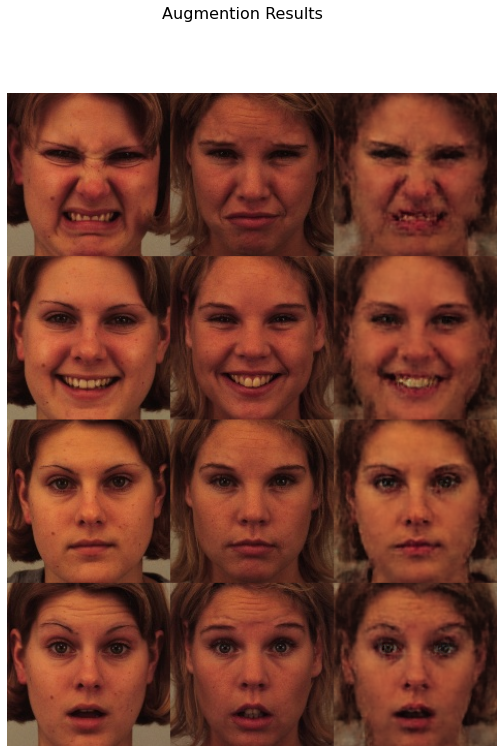

In [32]:
# Results on training set
DisplayResults(dataset_name).print_augmentation_result(model,
                                                       params["train_dataset"].data,
                                                       figure_width=10,
                                                       figure_height=12,
                                                       seed=23)

### Without Rotation Augmentation for Original Data

#### Without Synthesized

In [ ]:
ENABLE_ROTATION_IN_ORIGINAL_SET = False

(original_loader, augmented_loader, 
original_dataset, synthesized_dataset) = create_augmented_set(GCN,
                                                         params["train_dataset"].data,
                                                         device,
                                                         enable_rotation_augmentation=ENABLE_ROTATION_IN_ORIGINAL_SET)

In [ ]:
import gc
gc.collect()


dataset_name= "KDEF"
model_name = f"AlexNet_VAL_NOROT_NOSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    original_loader, 
    device=device,
    enable_lr_scheduler=False,
    max_epochs=MAX_EPOCHS,
    save_step=5,
    val_loader = params["val_loader"],
    enable_early_stopping=True,
    amp=True,
)

# trainer.load_model()

trainer.train()

epoch: 1.000	train_loss: 1.423	train_acc: 0.272	val_loss: 1.292	val_acc: 0.500


epoch: 2.000	train_loss: 1.301	train_acc: 0.407	val_loss: 0.970	val_acc: 0.643


epoch: 3.000	train_loss: 0.983	train_acc: 0.623	val_loss: 0.602	val_acc: 0.786


epoch: 4.000	train_loss: 0.860	train_acc: 0.636	val_loss: 0.942	val_acc: 0.571
INFO: Early stopping counter 1 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 5.000	train_loss: 0.777	train_acc: 0.722	val_loss: 0.231	val_acc: 0.929


epoch: 6.000	train_loss: 0.515	train_acc: 0.827	val_loss: 0.346	val_acc: 0.929
INFO: Early stopping counter 2 of 5


epoch: 7.000	train_loss: 0.441	train_acc: 0.815	val_loss: 0.106	val_acc: 1.000


epoch: 8.000	train_loss: 0.262	train_acc: 0.907	val_loss: 0.274	val_acc: 0.857
INFO: Early stopping counter 3 of 5


epoch: 9.000	train_loss: 0.380	train_acc: 0.858	val_loss: 0.142	val_acc: 0.929
INFO: Early stopping counter 4 of 5


epoch: 10.000	train_loss: 0.223	train_acc: 0.914	val_loss: 0.361	val_acc: 0.857
INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [ ]:
trainer.test(params["test_loader"])

{'test_acc': 0.22077922077922077, 'test_loss': 3.1512045860290527}

#### With Synthesized

In [ ]:
import gc
gc.collect()

dataset_name= "KDEF"
model_name = f"AlexNet_VAL_NOROT_WithSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    augmented_loader, 
    device=device,
    enable_lr_scheduler=True,
    max_epochs=MAX_EPOCHS,
    save_step=5,
    val_loader = params["val_loader"],
    enable_early_stopping=True,
    amp=True,
)

# trainer.load_model()

trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 1.000	train_loss: 0.233	train_acc: 0.914	val_loss: 0.666	val_acc: 0.929


epoch: 2.000	train_loss: 0.014	train_acc: 0.996	val_loss: 0.035	val_acc: 1.000


epoch: 3.000	train_loss: 0.005	train_acc: 0.998	val_loss: 0.186	val_acc: 0.857
INFO: Early stopping counter 1 of 5


epoch: 4.000	train_loss: 0.002	train_acc: 1.000	val_loss: 0.044	val_acc: 1.000
INFO: Early stopping counter 2 of 5


epoch: 5.000	train_loss: 0.001	train_acc: 1.000	val_loss: 0.153	val_acc: 0.929
INFO: Early stopping counter 3 of 5


epoch: 6.000	train_loss: 0.001	train_acc: 1.000	val_loss: 0.020	val_acc: 1.000


epoch: 7.000	train_loss: 0.001	train_acc: 1.000	val_loss: 0.085	val_acc: 0.929
INFO: Early stopping counter 4 of 5


epoch: 8.000	train_loss: 0.001	train_acc: 1.000	val_loss: 0.096	val_acc: 1.000
INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [ ]:
trainer.test(params["test_loader"])

{'test_acc': 0.948051948051948, 'test_loss': 0.32320234179496765}

### With Rotation Augmentation for Original Data

In [ ]:
assert type(GCN) == GANModel

ENABLE_ROTATION_IN_ORIGINAL_SET = True

(original_loader, augmented_loader, 
original_dataset, synthesized_dataset) = create_augmented_set(GCN,
                                                         params["train_dataset"].data,
                                                         device,
                                                         enable_rotation_augmentation=ENABLE_ROTATION_IN_ORIGINAL_SET)

#### Without Synthesized

In [ ]:
import gc
gc.collect()


dataset_name= "KDEF"
model_name = f"AlexNet_VAL_WithROT_NOSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False

EARLY_STOPPING_PATIENCE = 5

model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

trainer = ClassifierTrainer(
    model, 
    model_name, 
    original_loader, 
    device=device,
    enable_lr_scheduler=True,
    max_epochs=MAX_EPOCHS,
    save_step=5,
    val_loader = params["val_loader"],
    enable_early_stopping=True,
    amp=True,
)


trainer.train()

trainer.load_model()

epoch: 1.000	train_loss: 1.301	train_acc: 0.390	val_loss: 1.069	val_acc: 0.429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 2.000	train_loss: 0.808	train_acc: 0.669	val_loss: 0.418	val_acc: 0.857


epoch: 3.000	train_loss: 0.518	train_acc: 0.780	val_loss: 0.191	val_acc: 0.929


epoch: 4.000	train_loss: 0.393	train_acc: 0.847	val_loss: 0.183	val_acc: 0.929


epoch: 5.000	train_loss: 0.322	train_acc: 0.874	val_loss: 0.134	val_acc: 0.929


epoch: 6.000	train_loss: 0.291	train_acc: 0.881	val_loss: 0.155	val_acc: 0.929
INFO: Early stopping counter 1 of 5


epoch: 7.000	train_loss: 0.272	train_acc: 0.897	val_loss: 0.126	val_acc: 0.929


epoch: 8.000	train_loss: 0.267	train_acc: 0.906	val_loss: 0.121	val_acc: 1.000


epoch: 9.000	train_loss: 0.258	train_acc: 0.898	val_loss: 0.200	val_acc: 0.929
INFO: Early stopping counter 2 of 5


epoch: 10.000	train_loss: 0.241	train_acc: 0.920	val_loss: 0.133	val_acc: 1.000
INFO: Early stopping counter 3 of 5


epoch: 11.000	train_loss: 0.253	train_acc: 0.903	val_loss: 0.129	val_acc: 0.929
INFO: Early stopping counter 4 of 5


epoch: 12.000	train_loss: 0.247	train_acc: 0.908	val_loss: 0.139	val_acc: 0.929
INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [ ]:
trainer.test(params["test_loader"])

{'test_acc': 0.9090909090909091, 'test_loss': 0.2916770279407501}

#### With Synthesized

In [ ]:
import gc
gc.collect()

dataset_name= "KDEF"
model_name = f"AlexNet_VAL_WithROT_WithSYNTH_{dataset_name}"
dataset_type = "classifier"
model_type = "classifier"
debug = False


model = EmotionOnlyAlexNet(dataset_name="KDEF").to(device)

EARLY_STOPPING_PATIENCE = 5

trainer = ClassifierTrainer(
    model, 
    model_name, 
    augmented_loader, 
    device=device,
    enable_lr_scheduler=True,
    max_epochs=MAX_EPOCHS,
    save_step=5,
    val_loader = params["val_loader"],
    enable_early_stopping=True,
    amp=True,
)

trainer.train()

trainer.load_model()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


epoch: 1.000	train_loss: 0.351	train_acc: 0.856	val_loss: 0.414	val_acc: 0.929


epoch: 2.000	train_loss: 0.079	train_acc: 0.972	val_loss: 0.191	val_acc: 0.929


epoch: 3.000	train_loss: 0.032	train_acc: 0.990	val_loss: 0.005	val_acc: 1.000


epoch: 4.000	train_loss: 0.017	train_acc: 0.995	val_loss: 0.057	val_acc: 1.000
INFO: Early stopping counter 1 of 5


epoch: 5.000	train_loss: 0.007	train_acc: 0.998	val_loss: 0.005	val_acc: 1.000


epoch: 6.000	train_loss: 0.005	train_acc: 0.999	val_loss: 0.002	val_acc: 1.000


epoch: 7.000	train_loss: 0.005	train_acc: 0.999	val_loss: 0.005	val_acc: 1.000
INFO: Early stopping counter 2 of 5


epoch: 8.000	train_loss: 0.004	train_acc: 0.999	val_loss: 0.034	val_acc: 1.000
INFO: Early stopping counter 3 of 5


epoch: 9.000	train_loss: 0.004	train_acc: 0.999	val_loss: 0.003	val_acc: 1.000
INFO: Early stopping counter 4 of 5


epoch: 10.000	train_loss: 0.004	train_acc: 0.999	val_loss: 0.024	val_acc: 1.000
INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [ ]:
trainer.test(params["test_loader"])

{'test_acc': 0.935064935064935, 'test_loss': 0.3517363965511322}

# Experiment with Custom Res-GCN model

In [ ]:
dataset_name= "KDEF"
model_name = f"GCN_AUGMENTER_RES_WITHVAL_{dataset_name}"
dataset_type = "classifier"
model_type = "generator"
mode = "residual"
debug = False


params = Initializer.init_pretraining_params(dataset_name, 
                                             dataset_type,
                                             debug=debug,
                                             validation=True,
                                             seed=42)

Number of unique people in the training set of classification 45
Train Size: 45	 Val Size: 5	 Test Size: 20


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()


model = GANModel(size="small", 
                 dataset_name=dataset_name,
                 mode="residual",
                 dataset_type=dataset_type).to(device)
trainer = GeneratorTrainer(
    model, 
    model_name, 
    params["train_loader"],
    save_step = SAVE_STEP,
    report_step = REPORT_STEP,
    max_iters=MAX_ITERATIONS,
    device=device,
    enable_lr_scheduler=False,
    amp=True
)

trainer.opt = torch.optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

trainer.load_model()

In [ ]:
trainer.train()

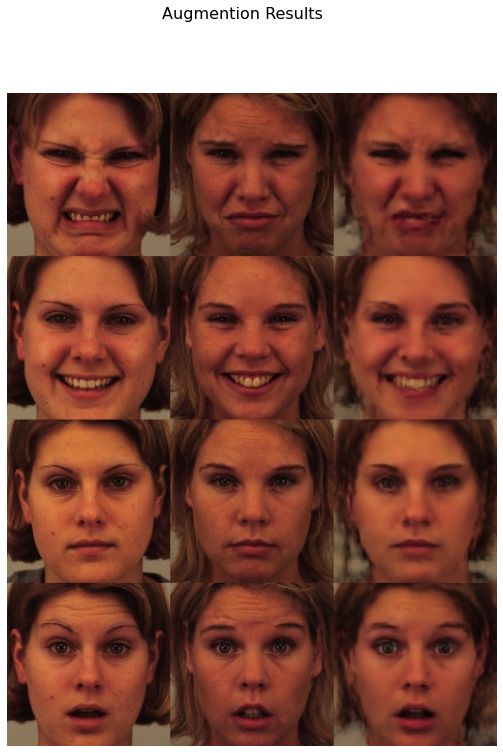

In [ ]:
# Results on training set
DisplayResults(dataset_name).print_augmentation_result(model,
                                                       params["train_dataset"].data,
                                                       figure_width=10,
                                                       figure_height=12,
                                                       seed=23)